# Classifying Audio Using Random Forest

Classifying toxic and non-toxic speech using a Random Forest Classifier.
___
Abhay Jolly | ajolly@sfu.ca\
Harry Preet Singh | hps1@sfu.ca\
Karan Pathania | kpathani@sfu.ca\
Neil Mukesh Shah | nmshah@sfu.ca
___
CMPT 419, Spring 2022\
Simon Fraser University

# 0. Preprocessing

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Set directories
PROJECT_DIR = '/content/drive/MyDrive/CMPT 419 Project'
AUDIO_DIR = os.path.join(PROJECT_DIR, 'audio_dataset')

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Function to print classification report and confusion matrix
def print_cr_cm(y_true, y_pred, labels=None):
  print('-' * 25, '\nClassification Report\n', '-' * 25, sep = '')
  print(classification_report(y_true, y_pred))

  print('-' * 25, '\nConfusion Matrix\n', '-' * 25, '\n', sep = '')
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
  plt.show()

# 1. Preparing data

In [3]:
train_df = pd.read_csv(os.path.join(AUDIO_DIR, 'audio_features_data', 'train_data.csv'))
test_df = pd.read_csv(os.path.join(AUDIO_DIR, 'audio_features_data', 'test_data.csv'))

train_labels = train_df['label'].values
test_labels = test_df['label'].values

train_df = train_df.drop(columns=['Filename', 'label'])
test_df = test_df.drop(columns=['Filename', 'label'])

In [4]:
print("Training features shape: ", train_df.shape)
print("Training labels shape: ", train_labels.shape)
print("Testing features shape: ", test_df.shape)
print("Testing labels shape: ", test_labels.shape)

Training features shape:  (368, 136)
Training labels shape:  (368,)
Testing features shape:  (123, 136)
Testing labels shape:  (123,)


# 2. Random Forest Model

In [6]:
# Standardize train dataset
X_std = StandardScaler().fit_transform(train_df)

model_rf = RandomForestClassifier(bootstrap=True, warm_start=True, random_state=419)

param_dist = {
    'n_estimators': [25, 100, 250, 500, 1000, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 4, 10, 20, 30, 40, 50, 100],
    'criterion': ['gini', 'entropy']
}

scorers = {
    'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score , average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

skf = StratifiedKFold(n_splits=4, shuffle = True)

clf_rf = RandomizedSearchCV(model_rf,
            param_dist,
            scoring=scorers,
            n_jobs=-1,
            cv=skf.split(X_std, train_labels),
            n_iter=30,
            refit='f1_score_weighted')

clf_rf.fit(X_std, train_labels.ravel())

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f7aa310f050>,
                   estimator=RandomForestClassifier(random_state=419,
                                                    warm_start=True),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 4, 10, 20, 30, 40,
                                                      50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [25, 100, 250, 500,
                                                         1000, 1500]},
                   refit='f1_score_weighted',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_score_weighted': make_scorer(f1_score, average=weighted),
                            'preci

In [7]:
rf = pd.DataFrame(clf_rf.cv_results_)
rf = rf[['param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion',
         'mean_test_f1_score_weighted', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_accuracy',
         'rank_test_accuracy', 'rank_test_f1_score_weighted']]
rf = rf.sort_values(by='rank_test_accuracy')

In [8]:
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'n_estimators': 1500, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}
0.84483552905615


# 3. Evaluation

-------------------------
Classification Report
-------------------------
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        62
           1       0.79      0.89      0.84        61

    accuracy                           0.83       123
   macro avg       0.83      0.83      0.83       123
weighted avg       0.83      0.83      0.83       123

-------------------------
Confusion Matrix
-------------------------



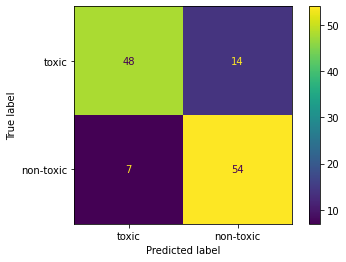

In [13]:
# Standardize train dataset
y_std = StandardScaler().fit_transform(test_df)

y_pred = clf_rf.predict(y_std)

print_cr_cm(test_labels.ravel(), y_pred, labels=['toxic', 'non-toxic'])

In [ ]:
rf = clf_rf.best_estimator_
rf.fit(X_std, train_labels.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=1500,
                       random_state=419, warm_start=True)

In [ ]:
# Save model to be loaded later
joblib.dump(rf, "/content/drive/MyDrive/CMPT 419 Project/Model_RF/random_forest.joblib")

['/content/drive/MyDrive/CMPT 419 Project/Model_RF/random_forest.joblib']